In [1]:
from CleanDriver_ff import Driver
from pfc import *
import numpy as np
from numpy import ma
import math
import time
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
plt.style.use('seaborn-paper')
%matplotlib inline

agg = np.load('loaded_data0.npy')
agg = np.array([[ agg[i][j] for i in range(len(agg)) ] for j in range(72) ])

In [2]:
""" Normalize a run between min and max"""
def normalize(run, min_, max_):
    """
    Args:
        run : array_like - the set of data we want to normalize
        min_ : float - the minimum value our result should take
        max_ : float - the maximum value our result should take
        
    Returns:
        array_like - normalized run
    """
    return min_ + ((run - np.min(run)) * (max_ - min_)) / (np.max(run) - np.min(run))

""" Inverse of 1/(1+e^(-x)) function"""
def inv_sig(x):
    return np.log(x / (1 - x))

""" 1/(1+e^(-x)) function"""
def sig(x):
    return 1 / (1 + np.exp(-x))

""" Not to be confused with sig(x) = 1/(1+e^(-x)), the sigmoid function is how
    we ask the network to report behavioral response variable"""
def sigmoid(x):
    return x / math.sqrt(100 + x * x)

pca = PCA(n_components=12, svd_solver='full')
projected_data = np.array([ pca.fit_transform(agg[i].T).T for i in range(72) ])
output_num = pca.n_components_ + 1 # target "neuron"
num_neurons = 700

# various behavioral response types
poss_maps = {
    'baseline': np.zeros(len(agg[0][0])),
    'pos'     : [sigmoid(i) for i in range(len(agg[0][0]))],
    'neg'     : [-1 * sigmoid(i) for i in range(len(agg[0][0]))],
    'r_pos'   : [1 - sigmoid(i) for i in range(100)],
    'r_neg'   : [-1 * (1 - sigmoid(i)) for i in range(100)],
    'base'    : np.zeros(100)
}

#  Configure training vectors; a vector takes the form:
#  [ color_coherence, motion_coherence, color_context, motion_context, return_cue ].
#  In the color context, color_context=1 & motion_context=0. In the motion context
#  color_context=0 & motion_context=1. No sensory evidence should be present when the
#  return cue is on.
cv   = [-0.5, -0.17, -0.05, 0.05, 0.17, 0.5] # color values
ret = [0, 0, 0, 0, 1] # return cue
vecs = []  # context / coherence vecs

for i in range(2):
    for j in range(len(cv)):
        for k in range(len(cv)):
            if i == 0: vecs.append((np.array([ cv[j], cv[k], 1, 0, 0 ]), True if cv[j] > 0 else False, 6*j + k))
            else: vecs.append((np.array([ cv[j], cv[k], 0, 1, 0 ]), True if cv[k] > 0 else False, 36+6*j+k))

appendpos = np.append(poss_maps['pos'], poss_maps['r_pos'])
appendneg = np.append(poss_maps['neg'], poss_maps['r_neg'])

In [3]:
# Set parameters for driver and initialize
time_constant = 0.1; chaotic_constant = 1.4; input_num = 5;
gg_sparseness = 0.9; alpha = 1.0; dt = 0.1;
p = 0.1; sigma = 0.0; epochs = 6;
driv = Driver(num_neurons, p, chaotic_constant, input_num, output_num, 
              gg_sparseness, alpha, dt, sigma, sig, target_in_network=True)

Initializing Driver...
 > > > > > Initializing network...
 > > > > > Network initialized.
Driver initialized.


In [4]:
# Train the network
base = np.zeros(80) # wait 200 ms
basenet = [ base for i in range(output_num) ]
def train(batch, vec):
    print '.',
    gain = [ np.linspace(0, batch[p][0], 20) for p in range(output_num) ]
    driv.train(gain, vec) # smooth gain
    driv.train(batch, vec) # correspondence between data and context    
    decline = [ np.linspace(batch[p][-1], 0, 20) for p in range(output_num) ]
    driv.train(decline, ret) # smooth decline   
    driv.train(basenet, ret)

start = time.time()
for epoch in range(epochs):
    print('')
    if epoch == int(round(float(epochs) / 4)):
        end = time.time()
        print('')
        print("[ 25%] training complete.", end - start, "seconds ellapsed.")
    if epoch == int(round(float(epochs) / 2)):
        end = time.time()
        print('')
        print("[ 50%] training complete.", end - start, "seconds ellapsed.")
    if epoch == int(round(3 * (float(epochs) / 4))):
        end = time.time()
        print('')
        print("[ 75%] training complete.", end - start, "seconds ellapsed.")
    np.random.shuffle(vecs)
    for i in range(len(vecs)):
        if i == len(vecs) / 2: 
            print('')
            print("Processed 50% of contexts")
        targ = list(projected_data[vecs[i][2]])
        if vecs[i][1]: targ.append(appendpos)
        else: targ.append(appendneg)
        train(targ, vecs[i][0])
end = time.time()
print('')
print("[100%] training complete.", end - start, "seconds ellapsed.")


.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Processed 50% of contexts
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Processed 50% of contexts
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

('[ 25%] training complete.', 159.50542283058167, 'seconds ellapsed.')
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Processed 50% of contexts
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

('[ 50%] training complete.', 239.83001279830933, 'seconds ellapsed.')
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Processed 50% of contexts
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Processed 50% of contexts
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [5]:
targ = [ [] for i in range(72) ]
ICs = []
res = [ [ [] for i in range(72) ] for t in range(5) ]
print(np.shape(res))
for q, noise in enumerate([0.0, 0.05, 0.1, 0.15, 0.2]):
    print('')
    print('Noise at', noise)
    for t in range(len(vecs)):
        print '.',
        for z in range(10):
            test = list(projected_data[t])
            if vecs[t][1]: test.append(appendpos)
            else: test.append(appendneg)

            gain = [ np.linspace(0, test[p][0], 20) for p in range(len(test)) ]
            phase_1 = driv.test(gain, vecs[t][0])
            ICs.append((driv.network.membrane_potential, vecs[t][0]))

            phase_2 = driv.test(test, vecs[t][0], twn=True, scale=noise)
            ICs.append((driv.network.membrane_potential, vecs[t][0]))

            drop = [ np.linspace(0, test[p][-1], 20) for p in range(len(test)) ]
            phase_3 = driv.test(drop, ret)
            ICs.append((driv.network.membrane_potential, vecs[t][0]))

            phase_4 = driv.test(basenet, ret)
            ICs.append((driv.network.membrane_potential, vecs[t][0]))
            if res[q][t] == []:
                res[q][t] = np.concatenate((phase_1, phase_2, phase_3, phase_4), axis=1)
            else:
                res[q][t] = res[q][t] + np.concatenate((phase_1, phase_2, phase_3, phase_4), axis=1)
        res[q][t] /= 10

(5, 72, 0)

('Noise at', 0.0)
.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
('Noise at', 0.05)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
('Noise at', 0.1)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
('Noise at', 0.15)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
('Noise at', 0.2)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


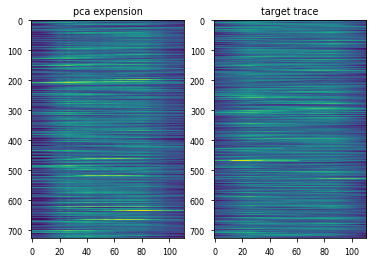

In [6]:
plt.figure()
plt.subplot(121)
plt.title('pca expension')
plt.imshow(pca.inverse_transform(np.array(res[0])[0][0:pca.n_components_,20:131].T).T, aspect='auto')
plt.subplot(122)
plt.title("target trace")
plt.imshow(agg[0], aspect='auto')

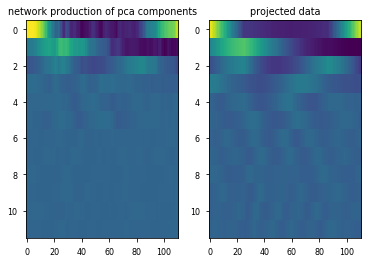

In [7]:
plt.figure()
plt.subplot(121)
plt.title('network production of pca components')
plt.imshow(np.array(res[0])[0][0:pca.n_components_,20:131], aspect='auto')
plt.subplot(122)
plt.title('projected data')
plt.imshow(projected_data[0], aspect='auto')